<a href="https://colab.research.google.com/github/DanPhala/python-projects/blob/main/StackOverFlow_comments_sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basic movie review classification ( negative or positive)

In [127]:
import tensorflow as tf
import string
import matplotlib.pyplot as plt
import os
import re
import shutil

from tensorflow.keras import layers
from tensorflow.keras import losses

In [128]:
print(f"tensorflow version -> : {tf.__version__}")

tensorflow version -> : 2.13.0


## Dataset used is called [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains text of 50 000 movie reviews from the [Internet Movies Database](https://www.imdb.com/). These are split into 25 000 reviews for training and 25 000 for testing.

In [129]:
#downloading the dataset
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url , untar = True, cache_dir='.', cache_subdir='.')

dataset_dir = os.path.join(os.path.dirname(dataset),  'aclImdb')

In [130]:
os.listdir(dataset_dir)

['test', 'README', 'imdbEr.txt', 'train', 'imdb.vocab']

###Getting training dataset path

In [131]:
train_dir = os.path.join(dataset_dir,  'train')
os.listdir(train_dir)


['urls_neg.txt',
 'unsupBow.feat',
 'urls_unsup.txt',
 'labeledBow.feat',
 'unsup',
 'urls_pos.txt',
 'neg',
 'pos']

In [132]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [133]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

### To prepare datase for binary classification we will have to split it into two folders for negative and positive dataset


#### I will further split the datasets into 3 (training, validation and testing) , validation will be 20 % data from training

#Training dataset

In [134]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
                                                          'aclImdb/train' ,
                                                          batch_size=batch_size,
                                                          validation_split=0.2,
                                                          subset='training',
                                                          seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


###Validation dataset

In [135]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
                                                        'aclImdb/train',
                                                        batch_size=batch_size,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


##Testing dataset

In [136]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory( 'aclImdb/train',
                                                          batch_size=batch_size)

Found 25000 files belonging to 2 classes.


#Preparing dataset for training

In [137]:
#customer function to remove html tags

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br  />', ' ')
  return  tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

###TextVectorization

In [138]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize=custom_standardization , max_tokens=max_features, output_mode='int' , output_sequence_length=sequence_length)

In [139]:
#Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x,y : x)
vectorize_layer.adapt(train_text)

In [140]:
#function that will hhelp us see the results from the vectorization layer
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [141]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0] , label_batch[0]

print(f"Review: {first_review}")
print(f"Label {raw_train_ds.class_names[first_label]}")
print(f"Vectorized review {vectorize_text(first_review, first_label)}")

Review: b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a

###Each token is replaced by the integer , i will call the .get_vocabulary() on this layer to show an example of which numbers corresponds to which token

In [142]:
print(f"2 -> {vectorize_layer.get_vocabulary()[2]}")
print(f"1422 -> {vectorize_layer.get_vocabulary()[1422]}")
print(f"1318 -> {vectorize_layer.get_vocabulary()[1318]}")

2 -> the
1422 -> emotions
1318 -> christopher


### Aplying the vecotirization layer to the entire dataset

In [143]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configuring the dataset for performance

In [144]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model

In [145]:
embedding_dim = 16

In [162]:
model = tf.keras.Sequential([
                            layers.Embedding(max_features + 1, embedding_dim),
                            layers.Dropout(0.2),
                            layers.GlobalAveragePooling1D(),
                            layers.Dropout(0.2),
                            layers.Dense(4)
                            ])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_22 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_6  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_23 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [163]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam' ,
              metrics=['accuracy'])

### Training the model

In [164]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.8448 - accuracy: 0.5501 - val_loss: 0.6838 - val_accuracy: 0.7758
Epoch 2/10
625/625 [==============================] - 5s 9ms/step - loss: 0.6623 - accuracy: 0.6400 - val_loss: 0.6274 - val_accuracy: 0.7846
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5999 - accuracy: 0.7145 - val_loss: 0.5582 - val_accuracy: 0.8046
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5301 - accuracy: 0.7701 - val_loss: 0.4895 - val_accuracy: 0.8290
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4625 - accuracy: 0.8160 - val_loss: 0.4328 - val_accuracy: 0.8458
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4104 - accuracy: 0.8386 - val_loss: 0.3913 - val_accuracy: 0.8554
Epoch 7/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3666 - accuracy: 0.8626 - val_loss: 0.3619 - val_accuracy: 0.8626
Epoch 

In [154]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 5s 7ms/step - loss: 0.2780 - accuracy: 0.8953
Loss: 0.2779940962791443
Accuracy: 0.8952800035476685


### Plotting the accuracy and loss overtime

In [155]:
#return history of everything that happened during training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

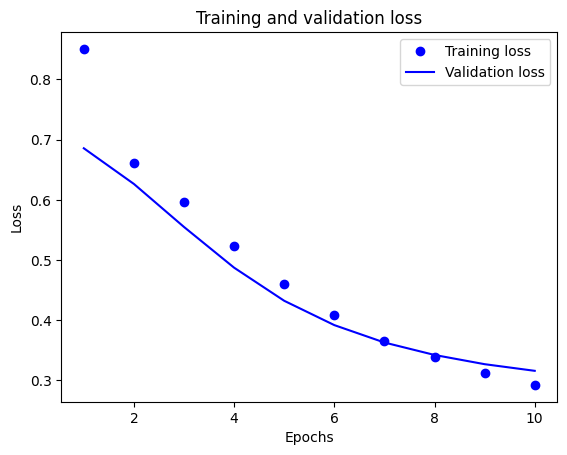

In [156]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


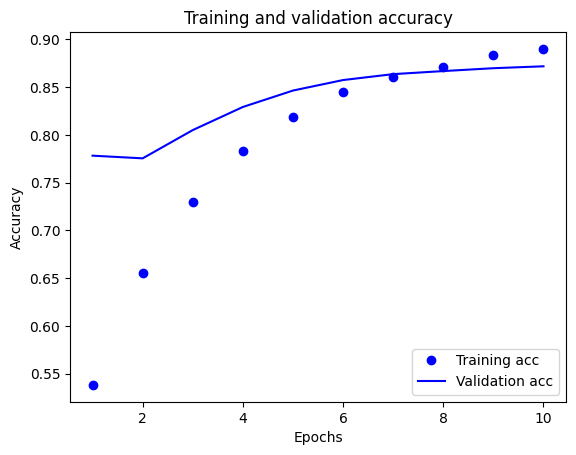

In [157]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

#Exporting the model

In [167]:
export_model = tf.keras.Sequential([ vectorize_layer ,
                                    model,
                                     layers.Activation('sigmoid')])

export_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(f"loss : {loss}")
print(f"accuracy : {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 6s 7ms/step - loss: 0.2771 - accuracy: 0.8944
loss : 0.27707639336586
accuracy : 0.8944000005722046


#Inference on new data

In [176]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..." ,
  "I am not really that sure about this movies but i think it was fucking amazing and terrible"
]
export_model.predict(examples)
predict_results = export_model.predict(examples)

for result in predict_results:
  for value in result:
    if value <= 0.3 :
      print(f" values -> {value} -> Negative")
    elif value >= 0.6:
      print(f" values -> {value} -> Possible")
    elif value > 0.3 and value < 0.6:
      print(f" values -> {value} -> Neutral")

1/1 [==============================] - 0s 40ms/step
 values -> 0.8572251796722412 -> Possible
 values -> 0.911674976348877 -> Possible
 values -> 0.004193843808025122 -> Negative
 values -> 0.006539097987115383 -> Negative
 values -> 0.8899008631706238 -> Possible
 values -> 0.8861734867095947 -> Possible
 values -> 0.004224811214953661 -> Negative
 values -> 0.006515164393931627 -> Negative
 values -> 0.9034777283668518 -> Possible
 values -> 0.8704286217689514 -> Possible
 values -> 0.004280744586139917 -> Negative
 values -> 0.006569770630449057 -> Negative
 values -> 0.8767332434654236 -> Possible
 values -> 0.9010128974914551 -> Possible
 values -> 0.004026421345770359 -> Negative
 values -> 0.00624753488227725 -> Negative
